In [100]:
from typing import List, Union
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble
from qiskit.compiler import transpile
from qiskit.circuit import Gate
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit.library import QFT
from qiskit import execute, Aer

In [101]:
def phase_return(index_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qr_index = QuantumRegister(index_qubits, "index")
    qc = QuantumCircuit(qr_index)

    ##############################
    ### U_1(gamma * (lambda2 - lambda1)) for each qubit ###
    # Provide your code here

    for qubit, lambda1, lambda2 in zip(qr_index, L1, L2):
        qc.p(-gamma * (lambda2 - lambda1), qubit)

    ##############################

    return qc.to_gate(label=" phase return ") if to_gate else qc


In [102]:
demoCircuit = QuantumCircuit(4)
demoCircuit.append(phase_return(4, 2*np.pi, [4,5,6,7], [5,6,8,8]), range(4))
demoCircuit.decompose().draw(output="text")

┌────────┐
q_0: ┤ P(-2π) ├
     ├────────┤
q_1: ┤ P(-2π) ├
     ├────────┤
q_2: ┤ P(-4π) ├
     ├────────┤
q_3: ┤ P(-2π) ├
     └────────┘

In [104]:
def subroutine_add_const(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qc = QuantumCircuit(data_qubits)
    ##############################
    ### Phase Rotation ###
    # Provide your code here

    phaseModule = 2*np.pi*const / (2**data_qubits)
    for idx in range(data_qubits):
        qc.p(phaseModule * 2**idx, idx)

    ##############################
    return qc.to_gate(label=" [+"+str(const)+"] ") if to_gate else qc


def const_adder(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qr_data = QuantumRegister(data_qubits, "data")
    qc = QuantumCircuit(qr_data)

    if np.abs(const) > 1e-3:
        ##############################
        ### QFT ###
        # Provide your code here
        qc.append(QFT(data_qubits).to_gate(), qr_data)

        ##############################

        ##############################
        ### Phase Rotation ###
        # Use `subroutine_add_const`
        qc.append(subroutine_add_const(
            data_qubits,
            const,
        ), qr_data)

        ##############################

        ##############################
        ### IQFT ###
        # Provide your code here
        qc.append(QFT(data_qubits, inverse=True).to_gate(), qr_data)

    ##############################
    return qc.to_gate(label=" [ +" + str(const) + "] ") if to_gate else qc


In [103]:
num_qubits = 4
demoCircuit = QuantumCircuit(num_qubits)
demoCircuit.append(const_adder(num_qubits, -7), range(num_qubits))
demoCircuit.measure_all()
job = execute(demoCircuit, Aer.get_backend("qasm_simulator"), shots=1024)
print(job.result().get_counts())

{'1001': 1024}


In [105]:
def cost_calculation(index_qubits: int, data_qubits: int, list1: list, list2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qr_index = QuantumRegister(index_qubits, "index")
    qr_data = QuantumRegister(data_qubits, "data")
    qc = QuantumCircuit(qr_index, qr_data)

    for i, (val1, val2) in enumerate(zip(list1, list2)):

        ##############################
        ### Add val2 using const_adder controlled by i-th index register (set to 1) ###
        # Provide your code here
        qc.append(
            const_adder(
                data_qubits,
                val2
            ).control(),
            [qr_index[i], *qr_data]
        )

        ##############################
        qc.x(qr_index[i])

        ##############################
        ### Add val1 using const_adder controlled by i-th index register (set to 0) ###
        # Provide your code here
        qc.append(
            const_adder(
                data_qubits,
                val1
            ).control(),
            [qr_index[i], *qr_data]
        )

        ##############################
        qc.x(qr_index[i])

    return qc.to_gate(label=" Cost Calculation ") if to_gate else qc


In [11]:
index_qubits = 2
data_qubits = 6
L1 = [1, 2]
L2 = [3, 4]
schedule = [1,1]
qr_index = QuantumRegister(index_qubits)
qr_data = QuantumRegister(data_qubits)
r_sum = ClassicalRegister(data_qubits)
demoCircuit = QuantumCircuit(qr_index, qr_data, r_sum)
for idx, val in enumerate(schedule):
    if val == 1:
        demoCircuit.x(qr_index[idx])
demoCircuit.append(
    cost_calculation(index_qubits, data_qubits, L1, L2), [*qr_index, *qr_data]
)
demoCircuit.barrier()
demoCircuit.measure(qr_data, r_sum)
job = execute(demoCircuit, Aer.get_backend("qasm_simulator"), shots=1024)
print(job.result().get_counts())

{'000111': 1024}


In [108]:
demoCircuit.decompose().draw(output="text")

┌──────┐┌──────────┐┌───────┐ ░ ┌─┐         
   q_0: ┤0     ├┤0         ├┤0      ├─░─┤M├─────────
        │      ││          ││       │ ░ └╥┘┌─┐      
   q_1: ┤1     ├┤1         ├┤1      ├─░──╫─┤M├──────
        │  QFT ││   [+-7]  ││  IQFT │ ░  ║ └╥┘┌─┐   
   q_2: ┤2     ├┤2         ├┤2      ├─░──╫──╫─┤M├───
        │      ││          ││       │ ░  ║  ║ └╥┘┌─┐
   q_3: ┤3     ├┤3         ├┤3      ├─░──╫──╫──╫─┤M├
        └──────┘└──────────┘└───────┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════╩══╩══╩══╩═
                                         0  1  2  3

In [117]:
def constraint_testing(data_qubits: int, C_max: int, to_gate=True) -> Union[Gate, QuantumCircuit]:

    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_data, qr_f)

    ##############################
    ### Set the flag register for indices with costs larger than C_max ###
    # Provide your code here

    c = int(np.log2(C_max+1)) + 1
    w = 2**c - (C_max+1)

    qc.append(
        const_adder(
            data_qubits,
            w
            ),
        qr_data
    )

    control_qubits = []
    for idx in range(c, data_qubits):
        qc.x(qr_data[idx])
        control_qubits.append(qr_data[idx])

    qc.mcx(control_qubits, qr_f)
    qc.x(qr_f[0])

    for idx in range(c, data_qubits):
        qc.x(qr_data[idx])

    qc.append(
        const_adder(
            data_qubits,
            w
        ).inverse(),
        qr_data
    )

    ##############################

    return qc.to_gate(label=" Constraint Testing ") if to_gate else qc


In [140]:
def reinitialization(index_qubits: int, data_qubits: int, C1: list, C2: list, C_max: int, to_gate=True) -> Union[Gate, QuantumCircuit]:

    qr_index = QuantumRegister(index_qubits, "index")
    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_index, qr_data, qr_f)

    ##############################
    ### Reinitialization Circuit ###
    # Provide your code here

    qc.append(
        constraint_testing(
            data_qubits,
            C_max
        ).inverse(),
        [*qr_data, *qr_f]
    )

    qc.append(
        cost_calculation(
            index_qubits,
            data_qubits,
            C1,
            C2
        ).inverse(),
        [*qr_index, *qr_data]
    )

    return qc.to_gate(label=" Reinitialization ") if to_gate else qc


In [128]:
target = 30
cmax = 20
num_qubits = 6

qr_data = QuantumRegister(num_qubits)
qr_f = QuantumRegister(1)
r_f = ClassicalRegister(1)
demoCircuit = QuantumCircuit(qr_data, qr_f, r_f)
demoCircuit.append(const_adder(num_qubits, target), qr_data)
demoCircuit.append(constraint_testing(num_qubits, cmax), [*qr_data, *qr_f])
demoCircuit.measure(qr_f, r_f)
job = execute(demoCircuit, Aer.get_backend("qasm_simulator"), shots=1024)
print(job.result().get_counts())


{'1': 1024}


In [142]:
index_qubits = 3
data_qubits = 6
C1 = [10, 3, 1]
C2 = [15, 7, 4]
C_max = 20

schedule = [1,1,0]

qr_data = QuantumRegister(data_qubits) 
cr_data = ClassicalRegister(data_qubits)

qr_index = QuantumRegister(index_qubits)
cr_index = ClassicalRegister(index_qubits)

qr_f = QuantumRegister(1)
r_f = ClassicalRegister(1)

demoCircuit = QuantumCircuit(qr_index, qr_data, qr_f, cr_index, cr_data, r_f)

for idx, val in enumerate(schedule):
    if val == 1:
        demoCircuit.x(qr_index[idx])

demoCircuit.append(cost_calculation(index_qubits, data_qubits, C1, C2), [*qr_index, * qr_data])
demoCircuit.append(constraint_testing(data_qubits, cmax), [*qr_data, *qr_f])

demoCircuit.measure(qr_index, cr_index)
demoCircuit.measure(qr_data, cr_data)
demoCircuit.measure(qr_f, r_f)

job = execute(demoCircuit, Aer.get_backend("qasm_simulator"), shots=1024)
demoCircuit.draw(output="text")
# print(job.result().get_counts())


┌───┐┌─────────────────────┐                         ┌─┐            »
q3378_0: ┤ X ├┤0                    ├─────────────────────────┤M├────────────»
         ├───┤│                     │                         └╥┘┌─┐         »
q3378_1: ┤ X ├┤1                    ├──────────────────────────╫─┤M├─────────»
         └───┘│                     │                          ║ └╥┘┌─┐      »
q3378_2: ─────┤2                    ├──────────────────────────╫──╫─┤M├──────»
              │                     │┌───────────────────────┐ ║  ║ └╥┘┌─┐   »
q3377_0: ─────┤3                    ├┤0                      ├─╫──╫──╫─┤M├───»
              │                     ││                       │ ║  ║  ║ └╥┘┌─┐»
q3377_1: ─────┤4  Cost Calculation  ├┤1                      ├─╫──╫──╫──╫─┤M├»
              │                     ││                       │ ║  ║  ║  ║ └╥┘»
q3377_2: ─────┤5                    ├┤2                      ├─╫──╫──╫──╫──╫─»
              │                     ││                       │ ║  ║  ║  ║  ║ »
q3377_3: ─────┤6                    ├┤3  Constraint Testing  ├─╫──╫──╫──╫──╫─»
              │                     ││                       │ ║  ║  ║  ║  ║ »
q3377_4: ─────┤7                    ├┤4                      ├─╫──╫──╫──╫──╫─»
              │                     ││                       │ ║  ║  ║  ║  ║ »
q3377_5: ─────┤8                    ├┤5                      ├─╫──╫──╫──╫──╫─»
              └─────────────────────┘│                       │ ║  ║  ║  ║  ║ »
q3379_0: ────────────────────────────┤6                      ├─╫──╫──╫──╫──╫─»
                                     └───────────────────────┘ ║  ║  ║  ║  ║ »
 c111: 3/══════════════════════════════════════════════════════╩══╩══╩══╬══╬═»
                                                               0  1  2  ║  ║ »
 c110: 6/═══════════════════════════════════════════════════════════════╩══╩═»
                                                                        0  1 »
 c112: 1/════════════════════════════════════════════════════════════════════»
                                                                             »
«                        
«q3378_0: ───────────────
«                        
«q3378_1: ───────────────
«                        
«q3378_2: ───────────────
«                        
«q3377_0: ───────────────
«                        
«q3377_1: ───────────────
«         ┌─┐            
«q3377_2: ┤M├────────────
«         └╥┘┌─┐         
«q3377_3: ─╫─┤M├─────────
«          ║ └╥┘┌─┐      
«q3377_4: ─╫──╫─┤M├──────
«          ║  ║ └╥┘┌─┐   
«q3377_5: ─╫──╫──╫─┤M├───
«          ║  ║  ║ └╥┘┌─┐
«q3379_0: ─╫──╫──╫──╫─┤M├
«          ║  ║  ║  ║ └╥┘
« c111: 3/═╬══╬══╬══╬══╬═
«          ║  ║  ║  ║  ║ 
« c110: 6/═╩══╩══╩══╩══╬═
«          2  3  4  5  ║ 
« c112: 1/═════════════╩═
«                      0

In [148]:
index_qubits = 3
data_qubits = 6
C1 = [10, 3, 1]
C2 = [5, 5, 4]
C_max = 16

schedule = [0, 1, 1]

qr_data = QuantumRegister(data_qubits)
cr_data = ClassicalRegister(data_qubits)

qr_index = QuantumRegister(index_qubits)
cr_index = ClassicalRegister(index_qubits)

qr_f = QuantumRegister(1)
r_f = ClassicalRegister(1)

demoCircuit = QuantumCircuit(qr_index, qr_data, qr_f, cr_index, cr_data, r_f)

for idx, val in enumerate(schedule):
    if val == 1:
        demoCircuit.x(qr_index[idx])

demoCircuit.append(cost_calculation(
    index_qubits, data_qubits, C1, C2), [*qr_index, * qr_data])
demoCircuit.barrier()
demoCircuit.append(constraint_testing(data_qubits, cmax), [*qr_data, *qr_f])
demoCircuit.barrier()
demoCircuit.append(reinitialization(index_qubits, data_qubits, C1, C2, C_max), [*qr_index, *qr_data, *qr_f])

demoCircuit.barrier()
demoCircuit.measure(qr_index, cr_index)
demoCircuit.measure(qr_data, cr_data)
demoCircuit.measure(qr_f, r_f)

job = execute(demoCircuit, Aer.get_backend("qasm_simulator"), shots=1024)
# demoCircuit.decompose().draw(output="text")
print(job.result().get_counts())


{'1 010011 110': 1024}


In [106]:
def penalty_dephasing(data_qubits: int, alpha: float, gamma: float, to_gate=True) -> Union[Gate, QuantumCircuit]:

    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_data, qr_f)

    ##############################
    ### Phase Rotation ###
    # Provide your code here

    for idx in range(data_qubits):
        qc.cp(-gamma * alpha * 2**idx, qr_f[0], qr_data[idx])

    ##############################

    return qc.to_gate(label=" Penalty Dephasing ") if to_gate else qc

    ##############################

In [ ]:
penalty_dephasing(5, 1, 1, to_gate = False).draw(output="text")

In [97]:
def solver_function(L1: list, L2: list, C1: list, C2: list, C_max: int) -> QuantumCircuit:
    
    # the number of qubits representing answers
    index_qubits = len(L1)
    
    # the maximum possible total cost
    max_c = sum([max(l0, l1) for l0, l1 in zip(C1, C2)])
    
    # the number of qubits representing data values can be defined using the maximum possible total cost as follows:
    data_qubits = math.ceil(math.log(max_c, 2)) + 1 if not max_c & (max_c - 1) == 0 else math.ceil(math.log(max_c, 2)) + 2
    
    ### Phase Operator ###
    # return part (OK)
    def phase_return(index_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
        qr_index = QuantumRegister(index_qubits, "index")
        qc = QuantumCircuit(qr_index)

        ##############################
        ### U_1(gamma * (lambda2 - lambda1)) for each qubit ###
        # Provide your code here

        for qubit, lambda1, lambda2 in zip(qr_index, L1, L2):
            qc.p(-gamma * (lambda2 - lambda1), qubit)

        ##############################

        return qc.to_gate(label=" phase return ") if to_gate else qc
    
    # penalty part (OK)
    def subroutine_add_const(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
        qc = QuantumCircuit(data_qubits)
        ##############################
        ### Phase Rotation ###
        # Provide your code here

        phaseModule = 2*np.pi*const / (2**data_qubits)
        for idx in range(data_qubits):
            qc.p(phaseModule * 2**idx, idx)

        ##############################
        return qc.to_gate(label=" [+"+str(const)+"] ") if to_gate else qc
        
        
        
        ##############################

    # penalty part (OK)
    def const_adder(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    
        qr_data = QuantumRegister(data_qubits, "data")
        qc = QuantumCircuit(qr_data)

        if np.abs(const) > 1e-3:
            ##############################
            ### QFT ###
            # Provide your code here
            qc.append(QFT(data_qubits).to_gate(), qr_data)


            ##############################

            ##############################
            ### Phase Rotation ###
            # Use `subroutine_add_const`
            qc.append(subroutine_add_const(
                data_qubits,
                const,
            ), qr_data)

            ##############################

            ##############################
            ### IQFT ###
            # Provide your code here
            qc.append(QFT(data_qubits, inverse=True).to_gate(), qr_data)


        ##############################
        return qc.to_gate(label=" [ +" + str(const) + "] ") if to_gate else qc
        
        
        
        ##############################
    
    # penalty part (OK)
    def cost_calculation(index_qubits: int, data_qubits: int, list1: list, list2: list, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
        qr_index = QuantumRegister(index_qubits, "index")
        qr_data = QuantumRegister(data_qubits, "data")
        qc = QuantumCircuit(qr_index, qr_data)

        for i, (val1, val2) in enumerate(zip(list1, list2)):

            ##############################
            ### Add val2 using const_adder controlled by i-th index register (set to 1) ###
            # Provide your code here
            qc.append(
                const_adder(
                    data_qubits,
                    val2
                ).control(),
                [qr_index[i], *qr_data]
            )


            ##############################
            qc.x(qr_index[i])

            ##############################
            ### Add val1 using const_adder controlled by i-th index register (set to 0) ###
            # Provide your code here
            qc.append(
                const_adder(
                    data_qubits,
                    val1
                ).control(),
                [qr_index[i], *qr_data]
            )


            ##############################
            qc.x(qr_index[i])

        return qc.to_gate(label=" Cost Calculation ") if to_gate else qc
        
        
        
        ##############################
    
    # penalty part (OK)
    def constraint_testing(data_qubits: int, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
        qr_data = QuantumRegister(data_qubits, "data")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_data, qr_f)

        ##############################
        ### Set the flag register for indices with costs larger than C_max ###
        # Provide your code here

        c = int(np.log2(C_max)) + 1
        w = 2**c - C_max

        qc.append(
            const_adder(
                data_qubits,
                w
            ),
            qr_data
        )

        control_qubits = []
        for idx in range(c, data_qubits):
            qc.x(qr_data[idx])
            control_qubits.append(qr_data[idx])

        qc.mcx(control_qubits, qr_f)
        qc.x(qr_f[0])

        for idx in range(c, data_qubits):
            qc.x(qr_data[idx])

        for idx in range(data_qubits):
            if idx != c:
                qc.x(qr_data[idx])

        qc.mcx(qr_data, qr_f)

        for idx in range(data_qubits):
            if idx != c:
                qc.x(qr_data[idx])

        qc.append(
            const_adder(
                data_qubits,
                w
            ).inverse(),
            qr_data
        )

        ##############################

        return qc.to_gate(label=" Constraint Testing ") if to_gate else qc
        
        
        
        ##############################
    
    # penalty part
    def penalty_dephasing(data_qubits: int, alpha: float, gamma: float, to_gate = True) -> Union[Gate, QuantumCircuit]:

        qr_data = QuantumRegister(data_qubits, "data")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_data, qr_f)

        ##############################
        ### Phase Rotation ###
        # Provide your code here

        for idx in range(data_qubits):
            qc.cp(gamma * alpha * 2**idx, qr_f[0], qr_data[idx])

        ##############################

        return qc.to_gate(label=" Penalty Dephasing ") if to_gate else qc
        
        
        
        ##############################
        
    # penalty part
    def reinitialization(index_qubits: int, data_qubits: int, C1: list, C2: list, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
        qr_index = QuantumRegister(index_qubits, "index")
        qr_data = QuantumRegister(data_qubits, "data")
        qr_f = QuantumRegister(1, "flag")
        qc = QuantumCircuit(qr_index, qr_data, qr_f)

        ##############################
        ### Reinitialization Circuit ###
        # Provide your code here

        qc.append(
            constraint_testing(
                data_qubits,
                C_max
            ).inverse(),
            [*qr_data, *qr_f]
        )

        qc.append(
            cost_calculation(
                index_qubits,
                data_qubits,
                C1,
                C2
            ).inverse(),
            [*qr_index, *qr_data]
        )



        ##############################

        return qc.to_gate(label=" Reinitialization ") if to_gate else qc
        
        
        
        ##############################

    ### Mixing Operator ###
    def mixing_operator(index_qubits: int, beta: float, to_gate = True) -> Union[Gate, QuantumCircuit]:
    
        qr_index = QuantumRegister(index_qubits, "index")
        qc = QuantumCircuit(qr_index)

        ##############################
        ### Mixing Operator ###
        # Provide your code here

        for qubit in qr_index:
            qc.rx(2*beta, qubit)



        ##############################

        return qc.to_gate(label=" Mixing Operator ") if to_gate else qc
        
        
        
        ##############################
    
    qr_index = QuantumRegister(index_qubits, "index") # index register
    qr_data = QuantumRegister(data_qubits, "data") # data register
    qr_f = QuantumRegister(1, "flag") # flag register
    cr_index = ClassicalRegister(index_qubits, "c_index") # classical register storing the measurement result of index register
    qc = QuantumCircuit(qr_index, qr_data, qr_f, cr_index)
    
    ### initialize the index register with uniform superposition state ###
    qc.h(qr_index)
    
    ### DO NOT CHANGE THE CODE BELOW
    p = 5
    alpha = 1
    for i in range(p):
        
        ### set fixed parameters for each round ###
        beta = 1 - (i + 1) / p
        gamma = (i + 1) / p
        
        ### return part ###
        qc.append(phase_return(index_qubits, gamma, L1, L2), qr_index)
        
        ### step 1: cost calculation ###
        qc.append(cost_calculation(index_qubits, data_qubits, C1, C2), qr_index[:] + qr_data[:])
        
        ### step 2: Constraint testing ###
        qc.append(constraint_testing(data_qubits, C_max), qr_data[:] + qr_f[:])
        
        ### step 3: penalty dephasing ###
        qc.append(penalty_dephasing(data_qubits, alpha, gamma), qr_data[:] + qr_f[:])
        
        ### step 4: reinitialization ###
        qc.append(reinitialization(index_qubits, data_qubits, C1, C2, C_max), qr_index[:] + qr_data[:] + qr_f[:])
        
        ### mixing operator ###
        qc.append(mixing_operator(index_qubits, beta), qr_index)

    ### measure the index ###
    ### since the default measurement outcome is shown in big endian, it is necessary to reverse the classical bits in order to unify the endian ###
    qc.measure(qr_index, cr_index[::-1])
    
    return qc


In [90]:
from qiskit.visualization import plot_histogram

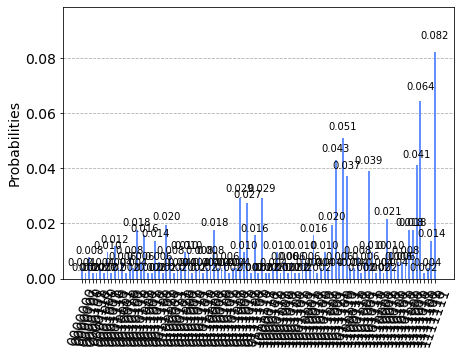

In [98]:
L1 = [5, 3, 3, 6, 9, 7, 1]
L2 = [8, 4, 5, 12, 10, 11, 2]
C1 = [1, 1, 2, 1, 1, 1, 2]
C2 = [3, 2, 3, 2, 4, 3, 3]
C_max = 16
demoCircuit = solver_function(L1, L2, C1, C2, C_max)
job = execute(demoCircuit, Aer.get_backend("qasm_simulator"), shots=512)
plot_histogram(job.result().get_counts())


In [99]:
print(job.result().get_counts().most_frequent())


1111111


In [ ]:
demoCircuit.decompose().draw(output="text")
